# Import common modules

In [1]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf 

2025-07-12 19:22:06.937395: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 19:22:07.361338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752340927.527056    5689 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752340927.577296    5689 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 19:22:07.997541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load data and normalize by event

In [2]:
def normalize_events(events):
    events_max = events.max(axis=1, keepdims=True)  # max per sample
    return events / events_max

def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max

with h5py.File('/home/filippo/DUNE/data/numu-CC-QE/lightweight_dataset_20cm.h5', 'r') as f:
    events = f['inputs'][:]
    truths = f['targets'][:]

X = normalize_events(events)
y = normalize_truths(truths)

## Plots to visualze data

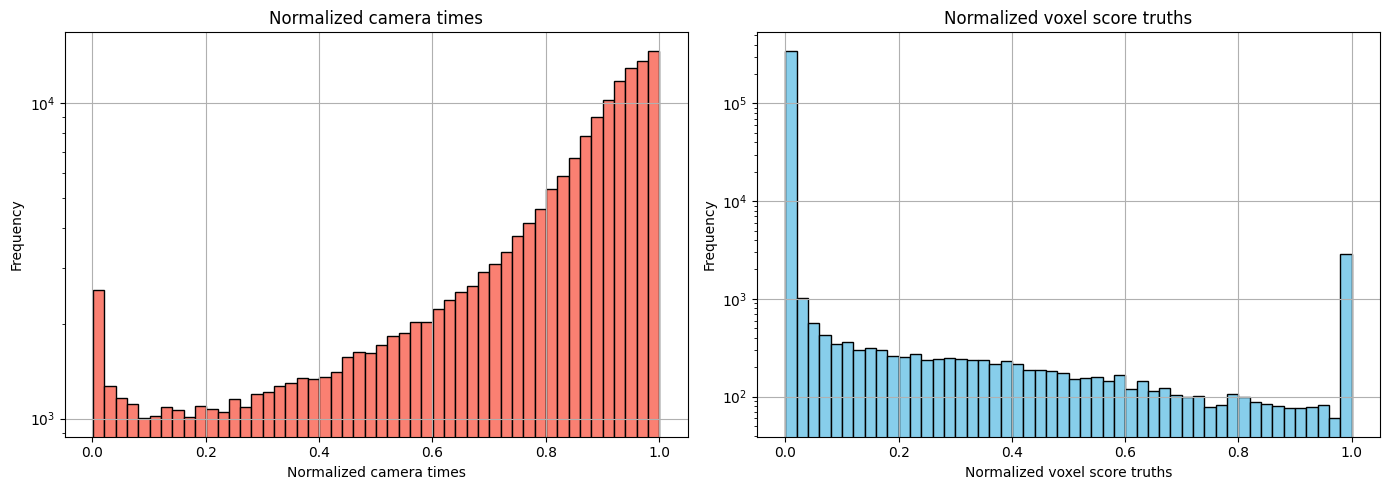

In [3]:
# Check normalization
plt.figure(figsize=(14, 5))

# Histogram of normalized event values (left)
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='salmon', edgecolor='black', log=True)
plt.xlabel('Normalized camera times')
plt.ylabel('Frequency')
plt.title('Normalized camera times')
plt.grid(True)

# Histogram of normalized truth values (right)
plt.subplot(1, 2, 2)
plt.hist(y.flatten(), bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Normalized voxel score truths')
plt.ylabel('Frequency')
plt.title('Normalized voxel score truths')
plt.grid(True)

plt.tight_layout()
plt.show()

# Make animation with input and expected output

n_samples = min(10, len(X))  # number of samples to animate

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1)             # Left plot: Event features (line plot)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Right plot: Voxel plot

# Prepare event feature line plot
line, = ax1.plot([], [], marker='o')
ax1.set_ylim(0, 1)
ax1.set_xlim(0, X.shape[1])
ax1.set_xlabel('Camera index')
ax1.set_ylabel('Normalized time')
ax1.grid(True)

# Prepare voxel plot color normalization and colormap
cmap = plt.get_cmap('magma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
mappable = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(mappable, ax=ax2, shrink=0.6, pad=0.1)
cbar.set_label('Normalized score')

def update(frame):
    sample_idx = frame
    truth_sample = y[sample_idx]
    event_features = X[sample_idx]

    # Update line plot (left)
    line.set_data(np.arange(len(event_features)), event_features)
    ax1.set_title(f'Camera times - Event {sample_idx}')

    # Clear and update voxel plot (right)
    ax2.cla()
    normed = truth_sample / truth_sample.max()
    filled = normed > 0.01
    colors = cmap(norm(normed))

    ax2.voxels(filled, facecolors=colors, edgecolor='k', linewidth=0.3)

    ax2.set_xlim([0, y.shape[1]]) 
    ax2.set_ylim([0, y.shape[2]])
    ax2.set_zlim([0, y.shape[3]])

    ax2.set_xlabel('voxel_ID_x')
    ax2.set_ylabel('voxel_ID_y')
    ax2.set_zlabel('voxel_ID_z')
    ax2.set_title(f'Voxel score truth - Event {sample_idx}')

    return [line]


ani = animation.FuncAnimation(fig, update, frames=n_samples, interval=1500, blit=False)

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

## Optimize model hyperparameters with Optuna

In [4]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class MaxNormalize1D(tf.keras.layers.Layer):
    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=1, keepdims=True)
        return inputs / (max_val + 1e-6)

In [5]:
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

input_dim = len(X[0])
output_shape = y[0].shape

# ---- Global Tracking Variables ----
best_model = None
best_history = None
best_val_loss = float("inf")
best_trial_number = None

# ---- Objective Function ----
def objective(trial):
    global best_model, best_history, best_val_loss, best_trial_number

    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(np.prod(output_shape), activation='relu'),
        MaxNormalize1D(),
        tf.keras.layers.Reshape(output_shape)
    ])

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")]
    )

    val_loss = min(history.history["val_loss"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history.history
        best_trial_number = trial.number

    return val_loss

# ---- Run Optuna Study ----

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# ---- Best Trial ----

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


/home/filippo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-12 19:23:51,728] A new study created in memory with name: no-name-dd8f6058-30b8-449f-9913-bbb3d943b5df
I0000 00:00:1752341035.064340    5689 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1752341037.960284    6915 service.cc:148] XLA service 0x7f331c016b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752341037.960754    6915 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-12 19:23:58.040292: I tensorflow/compiler/mlir/tensorflow/utils/du

Best trial:
  Value: 0.012767334468662739
  Params:
    optimizer: adam
    learning_rate: 0.000292946488611562
    dropout_rate: 0.10398078638850788
    batch_size: 64


## Training history of best model

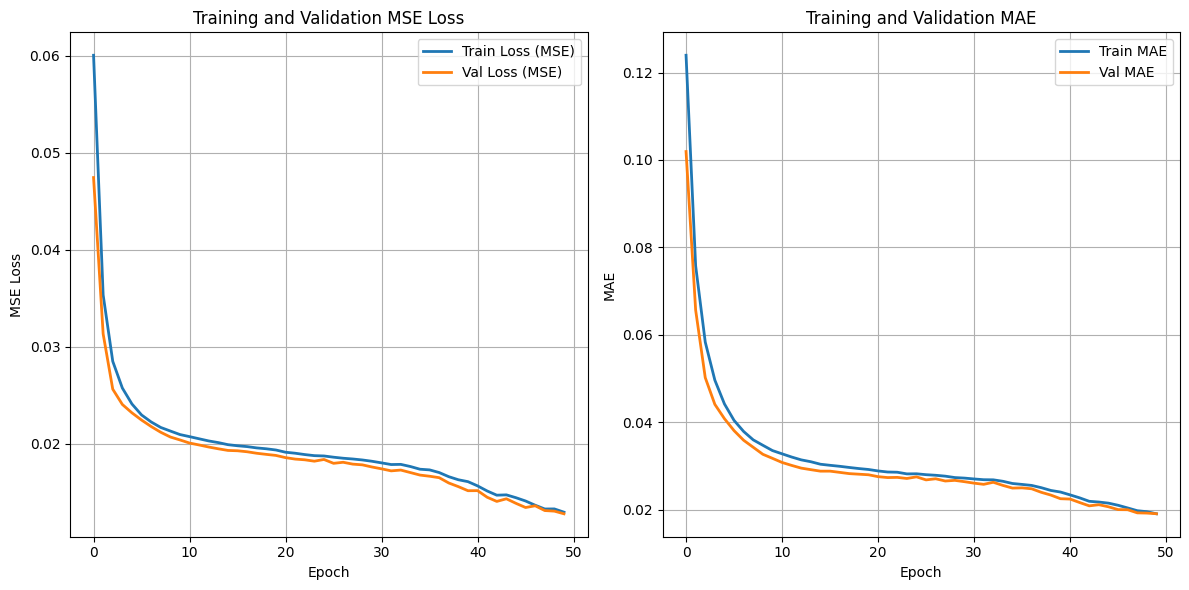

In [6]:
# ---- Plot loss and MAE curves ----
plt.figure(figsize=(12, 6))

# Plot MSE Loss
plt.subplot(1, 2, 1)
plt.plot(best_history['loss'], label='Train Loss (MSE)', lw=2)
plt.plot(best_history['val_loss'], label='Val Loss (MSE)', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(best_history['mae'], label='Train MAE', lw=2)
plt.plot(best_history['val_mae'], label='Val MAE', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Save best model

In [7]:
# Save the trained model to a file
best_model.save('/home/filippo/DUNE/pre-volumereco/saved_models/pre_volumereco_optuna_20cm.keras')

# Load previously saved model

In [8]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model(
    "/home/filippo/DUNE/pre-volumereco/saved_models/pre_volumereco_optuna_20cm.keras",
    custom_objects={"MaxNormalize1D": MaxNormalize1D},
    compile=True,
)

## Compare model predictions with truths

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
(1, 60) [[0.93489426 0.94791543 0.94565517 0.9349511  0.9400242  0.9434368
  0.9479125  0.94945216 0.97092366 0.9572394  0.9909718  0.967711
  0.9872744  0.8765774  0.8014729  0.98161703 0.9838823  0.990541
  0.99626225 0.99988025 0.05461305 0.24423704 0.8459334  0.6877235
  0.4647542  0.62223566 0.93954366 0.9363785  0.9420906  0.37205288
  0.9356054  0.92072725 0.9767127  0.9705137  0.97847354 0.98566175
  0.99294704 0.9223194  0.91771543 0.94913244 0.9230423  0.9116394
  0.92937833 0.95735896 0.9488765  0.9580307  0.9058364  0.15059723
  0.00112038 0.06641208 0.5676589  0.38087898 0.88025254 0.82735604
  0.9460521  0.9554735  0.9594913  0.98517174 0.9969531  1.        ]]


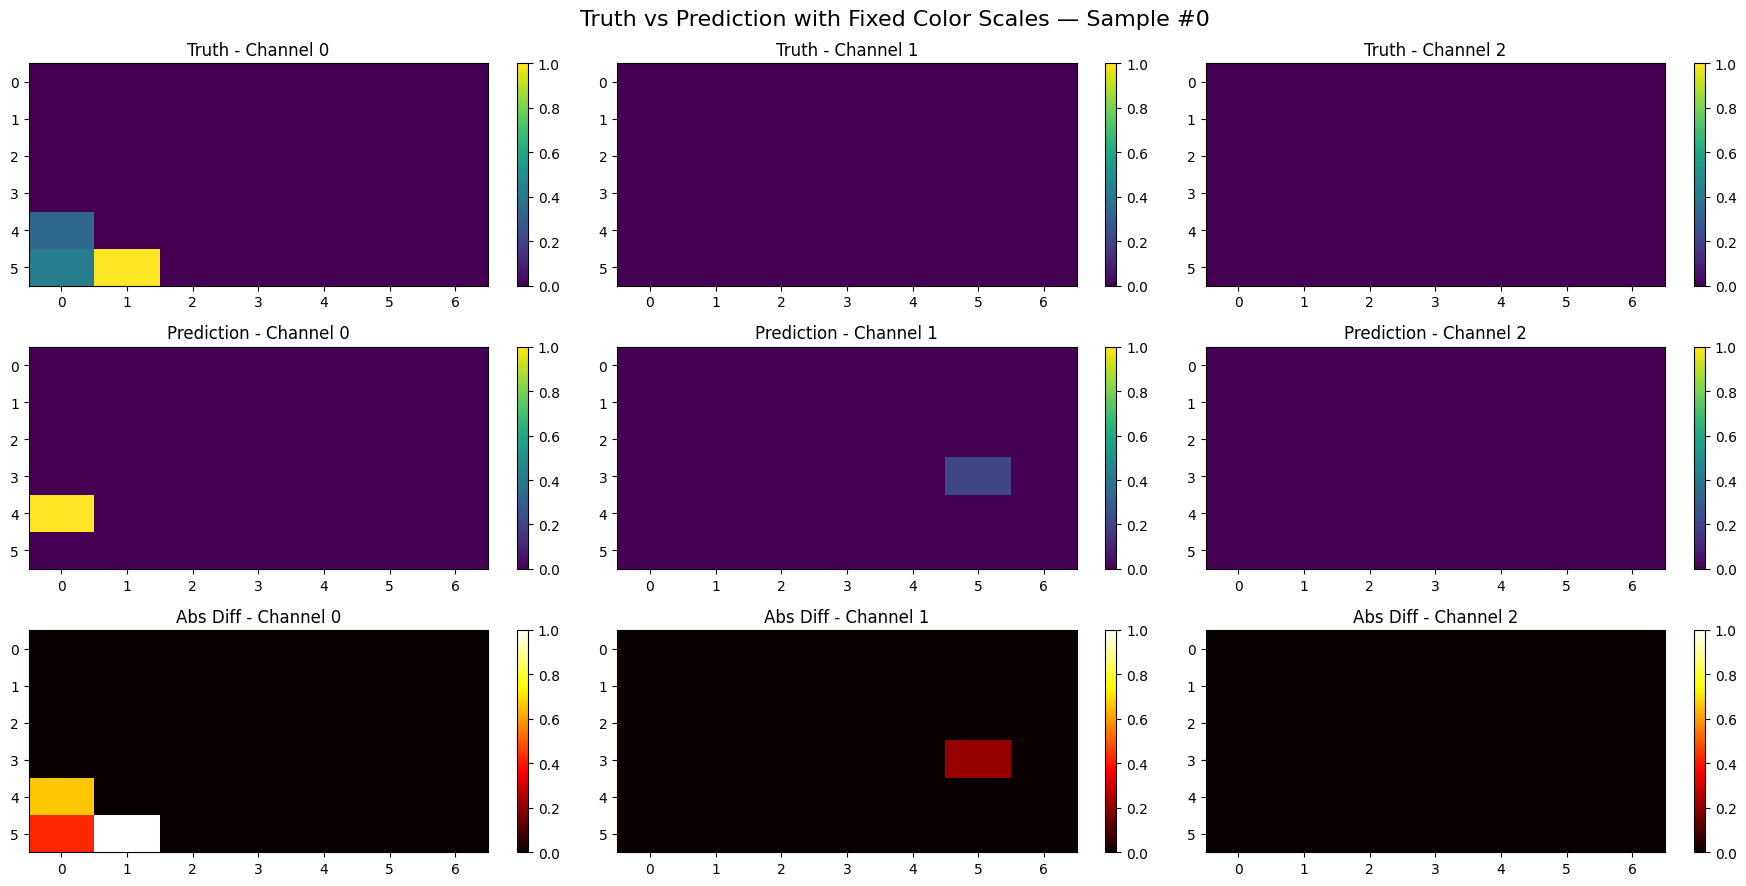

In [9]:
def plot_truth_vs_pred(truth, pred, sample_idx=0):
    fig, axes = plt.subplots(3, truth.shape[0], figsize=(18, 9))

    for i in range(truth.shape[0]):
        # Truth (fixed scale 0–1)
        im0 = axes[0, i].imshow(truth[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'Truth - Channel {i}')
        plt.colorbar(im0, ax=axes[0, i])

        # Prediction (fixed scale 0–1)
        im1 = axes[1, i].imshow(pred[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'Prediction - Channel {i}')
        plt.colorbar(im1, ax=axes[1, i])

        # Absolute Difference (fixed scale 0–1, or tweak if needed)
        im2 = axes[2, i].imshow(np.abs(truth[i] - pred[i]), cmap='hot', aspect='auto', vmin=0, vmax=1)
        axes[2, i].set_title(f'Abs Diff - Channel {i}')
        plt.colorbar(im2, ax=axes[2, i])

    plt.suptitle(f'Truth vs Prediction with Fixed Color Scales — Sample #{sample_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Get one prediction
sample_idx = 0
truth_sample = y[sample_idx]                                 
predicted = model.predict(X[sample_idx:sample_idx+1])[0]
print(X[sample_idx:sample_idx+1].shape, X[sample_idx:sample_idx+1])
plot_truth_vs_pred(y[sample_idx], predicted, sample_idx)

In [11]:
# Prepare data
X_vis = X[:10]
y_true = y[:10]
y_pred = model.predict(X_vis)

# Set up figure
fig = plt.figure(figsize=(12, 6))
ax_pred = fig.add_subplot(1, 2, 1, projection='3d')
ax_true = fig.add_subplot(1, 2, 2, projection='3d')

# Colormap
cmap = plt.get_cmap('magma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=[ax_pred, ax_true], shrink=0.6, pad=0.1).set_label('Normalized Value')

def update(frame):
    ax_pred.cla()
    ax_true.cla()

    pred = y_pred[frame]
    true = y_true[frame]

    pred_filled = pred > 0.01
    true_filled = true > 0.01

    pred_colors = cmap(norm(pred))
    true_colors = cmap(norm(true))

    ax_pred.voxels(pred_filled, facecolors=pred_colors, edgecolor='k', linewidth=0.2)
    ax_true.voxels(true_filled, facecolors=true_colors, edgecolor='k', linewidth=0.2)

    for ax, title in zip([ax_pred, ax_true], ['Prediction', 'Ground Truth']):
        ax.set_xlim([0, y.shape[1]])
        ax.set_ylim([0, y.shape[2]])
        ax.set_zlim([0, y.shape[3]])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(f'{title} - Event {frame}')

    return [ax_pred, ax_true]

ani = animation.FuncAnimation(fig, update, frames=len(X_vis), interval=1500, blit=False)

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


## Show model structure

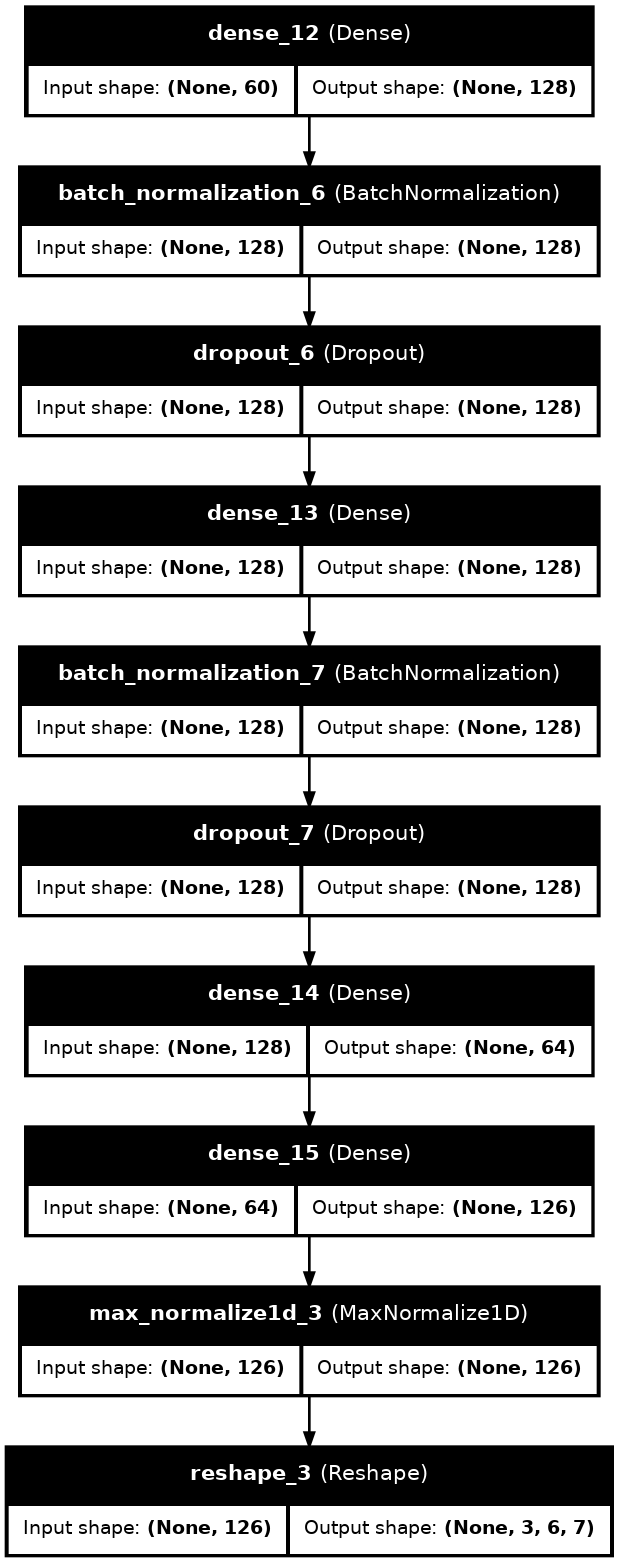

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    #to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)


# Check smearing

(27, 67, 69)


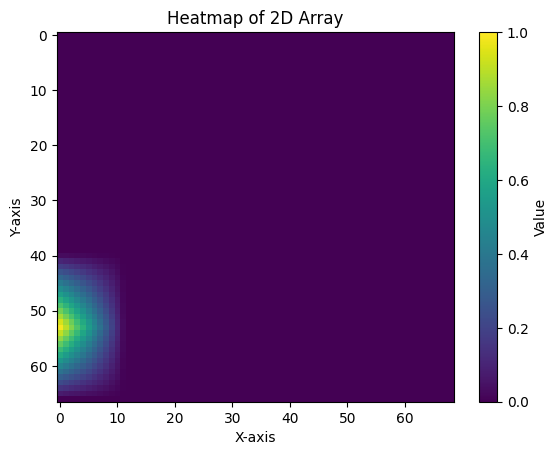

In [13]:
from scipy.ndimage import zoom

# Original array of shape (3, 6, 7)
expected_shape = (27, 67, 69)
zoom_factors = (expected_shape[0]/predicted.shape[0],expected_shape[1]/predicted.shape[1],expected_shape[2]/predicted.shape[2])  # Non-integer factors are fine
new_array = zoom(predicted, zoom_factors, order=1)
print(new_array.shape)

plt.imshow(new_array[0], cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Value')  # adds a color scale legend
plt.title('Heatmap of 2D Array')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()